In [1]:
import gym
import torch
import numpy as np
from utils import finalize
import math
import pickle

from model import MLPActorCritic

In [2]:
env = gym.make('BipedalWalker-v2')

obs_dim = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
initial_sd = .5

device = torch.device('cpu')

actor_critic = MLPActorCritic([obs_dim] + [32,32] + [2*num_actions], [obs_dim] + [32,32] + [1], initial_sd, num_actions, device)

version = "250"
modelname = "models/Bipedal/iteration" + version + ".pt"

sd = torch.load(modelname)
actor_critic.actor.load_state_dict(sd)

aggregate_name = "models/Bipedal/aggregate" + version + ".p"
with open(aggregate_name, 'rb') as filehandler:
    aggregate = pickle.load(filehandler)

Return: 309.08702950597325


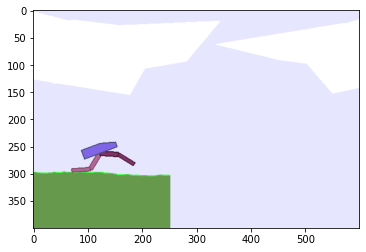

In [3]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline
import imageio

done = False
state = env.reset()

img = plt.imshow(env.render(mode='rgb_array')) # only call this once
frame_skip = 5
step = 0
r = 0
while not done:
    step += 1
    if step % frame_skip == 0:
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
    
    state_tensor = torch.as_tensor(np.array(state), dtype=torch.float32, device=device)
    state_tensor = state_tensor.unsqueeze(0)
    
    for i in range(obs_dim):
        mean, var = finalize(aggregate[i])
        state_tensor[:,i] = (state_tensor[:,i] - mean) / max(math.sqrt(var), 1e-6)
    
    action = actor_critic.get_action(state_tensor)
    
    state, reward, done, _ = env.step(action)
    r += reward
        
print(f"Return: {r}")